In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import cv2
import seaborn as sns 


input_data_path = '/kaggle/input/face-mask-detection/images'
annotations_path = "/kaggle/input/face-mask-detection/annotations"
images = [*os.listdir("/kaggle/input/face-mask-detection/images")]
output_data_path =  '.'


In [2]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [3]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [4]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss737,400,226,3,with_mask,28,55,46,71
1,maksssksksss737,400,226,3,with_mask,98,62,111,78
2,maksssksksss737,400,226,3,mask_weared_incorrect,159,50,193,90
3,maksssksksss737,400,226,3,with_mask,293,59,313,80
4,maksssksksss737,400,226,3,with_mask,352,51,372,72


In [5]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
#images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [6]:
df

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss737,400,226,3,with_mask,28,55,46,71
1,maksssksksss737,400,226,3,with_mask,98,62,111,78
2,maksssksksss737,400,226,3,mask_weared_incorrect,159,50,193,90
3,maksssksksss737,400,226,3,with_mask,293,59,313,80
4,maksssksksss737,400,226,3,with_mask,352,51,372,72
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss13,400,226,3,with_mask,229,53,241,72
4068,maksssksksss138,400,267,3,with_mask,51,144,128,239
4069,maksssksksss138,400,267,3,with_mask,147,169,217,233
4070,maksssksksss138,400,267,3,with_mask,224,92,309,186


In [7]:
df["name"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

Text(0, 0.5, 'name')

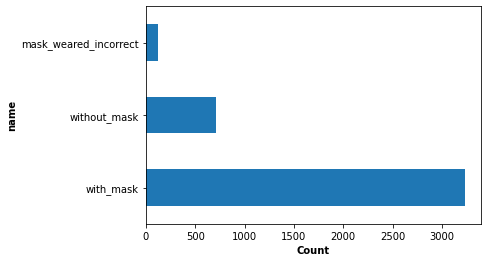

In [8]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

In [9]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [10]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [11]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [12]:
cropped_faces = [extract_faces(img, df) for img in images]

In [13]:
flat_cropped_faces = sum(cropped_faces, [])

In [14]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [15]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


In [16]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [17]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [18]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [19]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 35, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

In [20]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='/kaggle/working/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='/kaggle/working/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='/kaggle/working/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)


Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [21]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [22]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [24]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [25]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 4s 36ms/step - loss: 0.6494 - accuracy: 0.7600 - recall: 0.7400 - precision: 0.7769 - auc: 0.8857 - val_loss: 0.5577 - val_accuracy: 0.7917 - val_recall: 0.7917 - val_precision: 0.8028 - val_auc: 0.9216
Epoch 2/50
50/50 [==============================] - 1s 22ms/step - loss: 0.4623 - accuracy: 0.8250 - recall: 0.7800 - precision: 0.8548 - auc: 0.9431 - val_loss: 0.4347 - val_accuracy: 0.8472 - val_recall: 0.7361 - val_precision: 0.8548 - val_auc: 0.9491
Epoch 3/50
50/50 [==============================] - 1s 20ms/step - loss: 0.3604 - accuracy: 0.8875 - recall: 0.8675 - precision: 0.9036 - auc: 0.9674 - val_loss: 0.4475 - val_accuracy: 0.8333 - val_recall: 0.8056 - val_precision: 0.8286 - val_auc: 0.9446
Epoch 4/50
50/50 [==============================] - 1s 22ms/step - loss: 0.3614 - accuracy: 0.9050 - recall: 0.9000 - precision: 0.9114 - auc: 0.9656 - val_loss: 0.2093 - val_accuracy: 0.9444 - val_recall: 0.9028 - val_precision: 0.942

In [26]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

31/31 [==============================] - 0s 9ms/step - loss: 0.2269 - accuracy: 0.9177 - recall: 0.9177 - precision: 0.9253 - auc: 0.9833
0.22690197825431824 || 91.76954627037048 || 91.76954627037048 || 92.53112077713013 || 98.33188652992249


In [27]:
predictions = model.predict(test_generator)
# predictions

In [28]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0], color=['blue', 'red'])
    ax[0].set(xlabel='epoch number', ylabel='loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1], color=['green', 'pink'])
    ax[1].set(xlabel='epoch number', ylabel='accuracy')

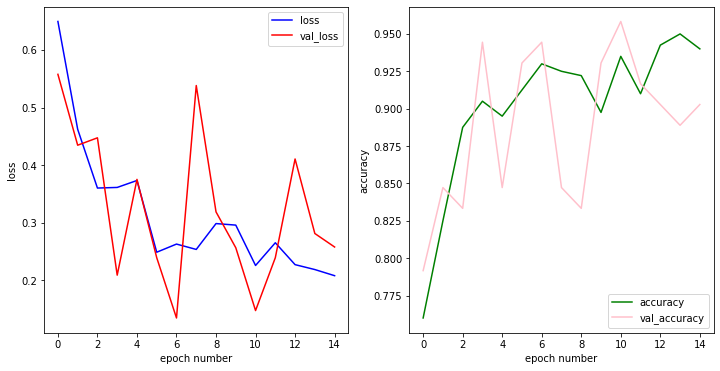

In [29]:
plot_loss_and_accuracy(model_history.history)

with_mask || with_mask


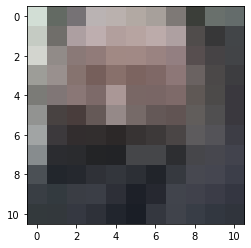

In [30]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

In [31]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

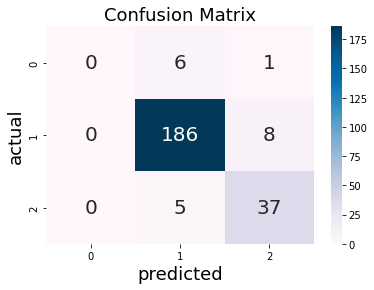

In [32]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [33]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  0, 197,  46])

In [34]:
# Save the entire model to a HDF5 file
model.save('model.h5')


In [35]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Load the weights of the model
model.load_weights('model.h5')

# Load the image file
img_path = '/kaggle/input/testimage/Photo on 8-1-23 at 3.56 AM.jpeg' # Replace with your image path
img = image.load_img(img_path, target_size=(35, 35))

# Preprocess the image
img_tensor = image.img_to_array(img)  # Converts the image to a numpy array
img_tensor = np.expand_dims(img_tensor, axis=0)  # Reshapes the image
img_tensor /= 255.  # Model was trained with inputs scaled to [0, 1]

# Use the model to make a prediction
prediction = model.predict(img_tensor)

# Decode the prediction
classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']  # Replace with your actual classes
predicted_class = classes[np.argmax(prediction)]

print(f'The image is most likely {predicted_class} with a {100 * np.max(prediction)} percent confidence.')


The image is most likely without_mask with a 67.85895228385925 percent confidence.
